In [12]:
from datetime import datetime
import os
os.chdir('..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import datajoint as dj
from pipeline import (reference, subject, acquisition, stimulation, analysis,
                      intracellular, extracellular, behavior, utilities)

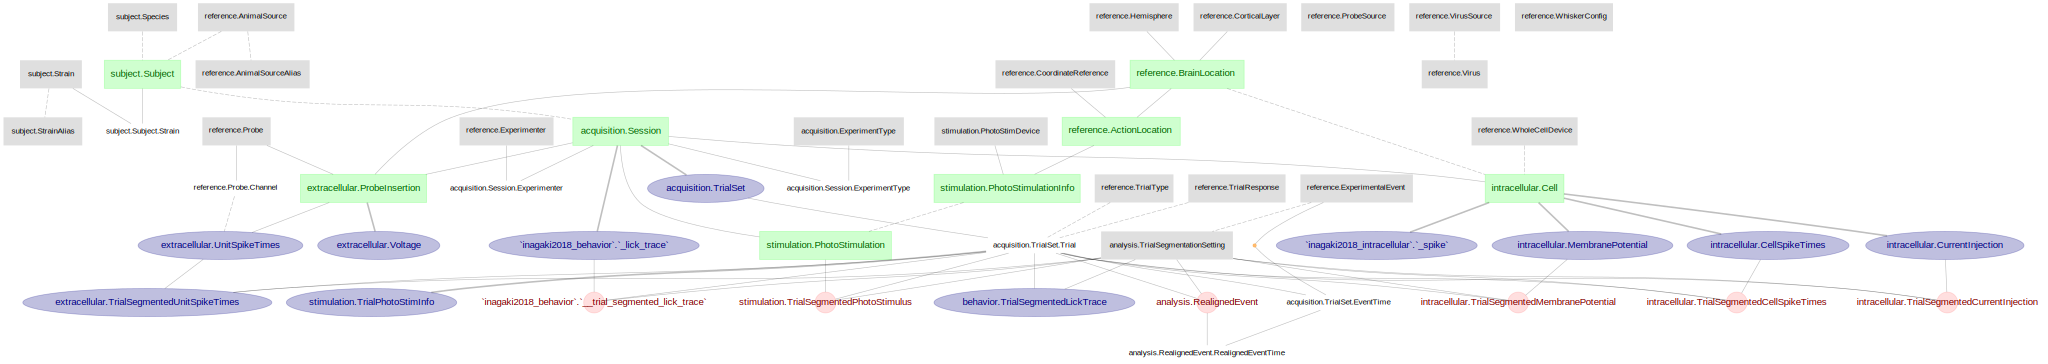

In [13]:
all_erd = (dj.ERD(reference) + dj.ERD(subject)
           + dj.ERD(acquisition) + dj.ERD(analysis)
           + dj.ERD(stimulation) + dj.ERD(behavior)
           + dj.ERD(extracellular) + dj.ERD(intracellular))
dj.ERD(all_erd)

## Reproduce Figure 2 - whole-cell

In [14]:
seg_param_key = (analysis.TrialSegmentationSetting & {'event': 'cue_start',
                                                      'pre_stim_duration': 3,
                                                      'post_stim_duration': 1}).fetch1()

In [15]:
nostim_contra_trials = {'trial_type': 'lick right', 'trial_response': 'correct', 'trial_stim_present': False}
nostim_ipsi_trials = {'trial_type': 'lick left', 'trial_response': 'correct', 'trial_stim_present': False}

In [16]:
cell_96 = (intracellular.Cell & {'cell_id': 'cell_96'}
           & (acquisition.Session.ExperimentType & {'experiment_type': 'regular'})).fetch('KEY')

In [17]:
# Membrane Potential
contra_trial_mp, contra_trial_mp_wo_spike = (intracellular.TrialSegmentedMembranePotential & cell_96 & seg_param_key &
                 (acquisition.TrialSet.Trial & nostim_contra_trials)).fetch('segmented_mp', 'segmented_mp_wo_spike')
ipsi_trial_mp, ipsi_trial_mp_wo_spike = (intracellular.TrialSegmentedMembranePotential & cell_96 & seg_param_key &
                 (acquisition.TrialSet.Trial & nostim_ipsi_trials)).fetch('segmented_mp', 'segmented_mp_wo_spike')
# Spikes
contra_trial_spiketimes = (intracellular.TrialSegmentedCellSpikeTimes & cell_96 & seg_param_key &
                 (acquisition.TrialSet.Trial & nostim_contra_trials)).fetch('segmented_spike_times')
ipsi_trial_spiketimes = (intracellular.TrialSegmentedCellSpikeTimes & cell_96 & seg_param_key &
                 (acquisition.TrialSet.Trial & nostim_ipsi_trials)).fetch('segmented_spike_times')

In [18]:
# Event times
events, event_times = (analysis.RealignedEvent.RealignedEventTime & cell_96 &
                      (acquisition.TrialSet.Trial & [{'trial_response': 'correct'},
                                                     {'trial_response': 'incorrect'}])).fetch('trial_event',
                                                                                              'realigned_event_time')

In [19]:
# Calculate mean event times across trials
mean_event_times = {name: np.nanmean([t for n, t in zip(events, event_times) if n == name]) for name in set(events)}

In [20]:
# Construct time vector
fs = intracellular.MembranePotential.fetch('membrane_potential_sampling_rate', limit=1).item()
timestamps = np.arange(-1 * float(seg_param_key['pre_stim_duration']) * fs,
                       float(seg_param_key['post_stim_duration']) * fs + 1) / fs

In [21]:
# Spike histogram 
bin_counts = 100
contra_trial_spikecounts, contra_edges = np.histogram(np.hstack(contra_trial_spiketimes).flatten(), 
                                                      bins=bin_counts, range=(timestamps[0], timestamps[-1]))
contra_trial_spikerate = contra_trial_spikecounts / np.diff(contra_edges) / contra_trial_spiketimes.size

ipsi_trial_spikecounts, ipsi_edges = np.histogram(np.hstack(ipsi_trial_spiketimes).flatten(), 
                                                      bins=bin_counts, range=(timestamps[0], timestamps[-1]))
ipsi_trial_spikerate = ipsi_trial_spikecounts / np.diff(ipsi_edges) / ipsi_trial_spiketimes.size

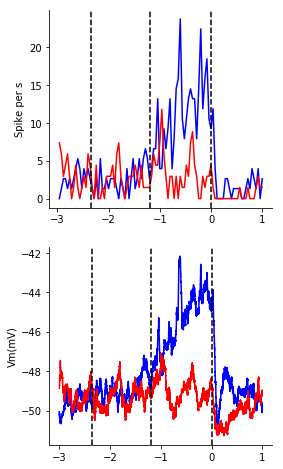

In [22]:
# Reproduce Figure 2b 
fig3b, axs = plt.subplots(2, 1, figsize=(4, 8))

axs[0].plot(contra_edges[1:], contra_trial_spikerate, 'b')
axs[0].plot(ipsi_edges[1:], ipsi_trial_spikerate, 'r')
# event markers
for e in ('sampling_start', 'delay_start', 'cue_start'):
    axs[0].axvline(x=mean_event_times[e], linestyle='--', color='k')
axs[0].set_ylabel('Spike per s')
# Hide the spines
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)

axs[1].plot(timestamps, np.vstack(contra_trial_mp_wo_spike).mean(axis=0), 'b')
axs[1].plot(timestamps, np.vstack(ipsi_trial_mp_wo_spike).mean(axis=0), 'r')
# event markers
for e in ('sampling_start', 'delay_start', 'cue_start'):
    axs[1].axvline(x=mean_event_times[e], linestyle='--', color='k')
axs[1].set_ylabel('Vm(mV)')
# Hide the spines
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)

In [24]:
# Single trial - correct lick right trials (contra-trial) #2 ~ 7
contra_trial_lick_right  = (behavior.TrialSegmentedLickTrace & cell_96 & seg_param_key &
                 (acquisition.TrialSet.Trial & nostim_contra_trials)).fetch('segmented_lick_right_on')

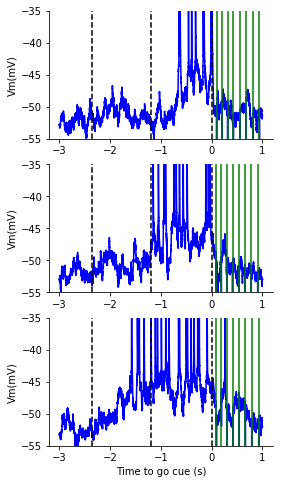

In [48]:
# Reproduce Figure 2c
trials = np.arange(2,5)
fig3c, axs = plt.subplots(trials.size, 1, figsize=(4, 8))
fig3c.subplots_adjust(hspace=0.2)
for ax, tr in zip(axs, trials):
    ax.plot(timestamps, contra_trial_mp[tr], 'b')
    # lick times
    for t in contra_trial_lick_right[tr]:
        ax.axvline(x=t, linestyle='-', color='g')
    # event markers
    for e in ('sampling_start', 'delay_start', 'cue_start'):
        ax.axvline(x=mean_event_times[e], linestyle='--', color='k')
    ax.set_ylabel('Vm(mV)')
    ax.set_ylim((-55, -35))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
axs[-1].set_xlabel('Time to go cue (s)');

## Reproduce Figure 5 - extra-cellular - fixed-delay

## Reproduce Figure 3 - whole-cell

In [ ]:
def query_segmented_intracellular(cell_key, trial_key, seg_param_key):
    data_keys = (intracellular.TrialSegmentedMembranePotential & cell_key & seg_param_key &
                 (acquisition.TrialSet.Trial & trial_key))
    return [{**dict(zip(['segmented_mp', 'segmented_mp_wo_spike'],
                        (intracellular.TrialSegmentedIntracellular.MembranePotential & k).fetch1(
                            'segmented_mp', 'segmented_mp_wo_spike'))),
             **dict(zip(*(acquisition.TrialSet.RealignedEventTime & k).fetch(
                 'realigned_trial_event', 'realigned_event_time')))}
            for k in data_keys]

In [ ]:
tmp = query_segmented_intracellular(cell_96, nostim_contra_trials, seg_param_key)

In [ ]:
cell_key = cells['cell_96']['wo_current_injection']
tmp = query_segmented_intracellular(cell_key, contra_trials, seg_param_key)


In [ ]:
(intracellular.TrialSegmentedMembranePotential & cell_key & seg_param_key) * (acquisition.TrialSet.Trial)

In [ ]:
intracellular.TrialSegmentedMembranePotential & 'cell_id="cell_96"'

In [ ]:
(acquisition.TrialSet.Trial & contra_trials)

In [ ]:
set(intracellular.TrialSegmentedMembranePotential.fetch('cell_id'))

In [ ]:
cell_mps = {cell: {'w_current_injection': {'contra': (intracellular.TrialSegmentedMembranePotential 
                                                      & c_val['w_current_injection'] & seg_param_key & contra_trials),
                                           'ipsi': {}},
                   'wo_current_injection': {'contra': {},
                                           'ipsi': {}}
                  } for cell, c_val in cells.items}